In [ ]:
'''Prueba con imagen y label de ejemplo'''

In [45]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
from vcd import core, utils, draw, scl

MAX_DISTANCE = 15.0
BEV_HEIGHT = 1024
BEV_WIDTH = 1024
CS_REF = "train"

class BEVGenerator:
    def __init__(self, cam_name, img_path, openlabel_path, output_path):
        self.camera_name    = cam_name
        self.img_path       = img_path
        self.openlabel_path = openlabel_path
        self.output_path    = output_path

        # Cargo la imagen
        self.img = cv2.imread(self.img_path)
        if self.img is None:
            raise FileNotFoundError(f"No se pudo leer la imagen: {self.img_path}")

        # Cargo anotaciones y construyo la escena
        self.vcd = core.VCD()
        self.vcd.load_from_file(self.openlabel_path)
        self.scene = scl.Scene(self.vcd)

        # Parámetros BEV
        aspect = BEV_WIDTH / BEV_HEIGHT
        x_range = (0.0, MAX_DISTANCE)
        y_half = (x_range[1] - x_range[0]) / aspect / 2
        y_range = (-y_half, y_half)

        self.params = draw.TopView.Params(
            color_map=utils.COLORMAP_1,
            topview_size=(BEV_WIDTH, BEV_HEIGHT),
            background_color=0,
            range_x=x_range,
            range_y=y_range,
            step_x=1.0,
            step_y=1.0,
            draw_grid=True
        )

    def src_img2bev(self, frame_num: int = 0):
        drawer = draw.TopView(
            scene=self.scene,
            coordinate_system=CS_REF,
            params=self.params
        )
        drawer.add_images(imgs={self.camera_name: self.img}, frame_num=frame_num)
        drawer.draw_bevs(_frame_num=frame_num)

        bev_img = drawer.topView
        os.makedirs(os.path.dirname(self.output_path), exist_ok=True)
        cv2.imwrite(self.output_path, bev_img)
        print(f"[OK] {os.path.basename(self.img_path)} → {os.path.basename(self.output_path)}")


def main():
    base_dir   = r"C:/Users/usuario/Desktop/CAF/VS_CAF/CAF/Data_3D_2D/Train"
    images_dir = os.path.join(base_dir, "input", "images")
    label_dir  = os.path.join(base_dir, "input", "label")
    output_dir = os.path.join(base_dir, "output")

    # Buscamos un JSON (por ejemplo "openlabel.json") dentro de label_dir
    json_files = glob.glob(os.path.join(label_dir, "*.json"))
    if not json_files:
        print("No hay ningún .json en:", label_dir)
        return
    # Si hay varios JSON, puedes ajustar aquí cómo elegir cuál usar
    openlabel_path = json_files[0]
    print("Usando etiquetas de:", os.path.basename(openlabel_path))

    # Recogemos todas las imágenes (.png/.jpg)
    img_patterns = ["*.png", "*.jpg", "*.jpeg"]
    image_paths = []
    for p in img_patterns:
        image_paths.extend(glob.glob(os.path.join(images_dir, p)))
    if not image_paths:
        print("No se encontraron imágenes en:", images_dir)
        return

    # Procesamos cada imagen con el mismo JSON
    for img_path in sorted(image_paths):
        name, _ = os.path.splitext(os.path.basename(img_path))
        output_path = os.path.join(output_dir, f"{name}_topview.png")

        bev = BEVGenerator(
            cam_name="cam",
            img_path=img_path,
            openlabel_path=openlabel_path,
            output_path=output_path
        )
        bev.src_img2bev(frame_num=0)

    print("✔️  Procesadas todas las imágenes con el mismo JSON.")

if __name__ == "__main__":
    main()


: 

In [ ]:
'''Lo hacemos para las imágenes de la scene-0916'''

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from nuscenes.nuscenes import NuScenes
from vcd import core, utils, draw, scl

# === Parámetros BEV ===
MAX_DISTANCE = 25.0
BEV_HEIGHT   = 1024
BEV_WIDTH    = 1024
CS_REF       = "vehicle-iso8855"
scene_name  = "scene-0916"

class BEVGenerator():
    def __init__(self, cam_name, img_path, openlabel, output):
        self.camera_name = cam_name        
        self.img = cv2.imread(img_path)
        self.vcd = core.VCD()
        self.vcd.load_from_file(openlabel)
        self.scene = scl.Scene(self.vcd)
        self.output_folder = output

        bev_aspect_ratio = BEV_WIDTH / BEV_HEIGHT
        bev_x_range = (0.0, MAX_DISTANCE)
        bev_y_range = (
            -((bev_x_range[1] - bev_x_range[0]) / bev_aspect_ratio) / 2,
             ((bev_x_range[1] - bev_x_range[0]) / bev_aspect_ratio) / 2
        )
        self.bev_parameters = draw.TopView.Params(
            color_map       = utils.COLORMAP_1,
            topview_size    = (BEV_WIDTH, BEV_HEIGHT),
            background_color= 0,
            range_x         = bev_x_range,
            range_y         = bev_y_range,
            step_x          = 1.0,
            step_y          = 1.0,
            draw_grid       = True
        )

    def src_img2bev(self):
        drawer = draw.TopView(
            scene             = self.scene,
            coordinate_system = CS_REF,
            params            = self.bev_parameters
        )
        drawer.add_images(imgs={self.camera_name: self.img}, frame_num=0)
        drawer.draw_bevs(_frame_num=0)
        bev_img = drawer.topView
        cv2.imwrite(self.output_folder, bev_img)


def main(camera_name, image_path, openlabel_path, output_path):
    bev = BEVGenerator(
        cam_name   = camera_name,
        img_path   = image_path,
        openlabel  = openlabel_path,
        output     = output_path
    )
    bev.src_img2bev()


# === Rutas ===
DATASET_PATH  = "C:/Users/usuario/Desktop/CAF/v1.0-mini_canbus-001"
OPENLABEL     = "C:/Users/usuario/Desktop/CAF/VS_CAF/CAF/Data_3D_2D/NuScenes/input/label/coche1.json"
OUTPUT_DIR    = "C:/Users/usuario/Desktop/CAF/VS_CAF/CAF/Data_3D_2D/NuScenes/output_bev"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Inicializa NuScenes y busca escena 0916 ===
nusc = NuScenes(version='v1.0-mini', dataroot=DATASET_PATH, verbose=False)
scene = next(s for s in nusc.scene if s['name']==scene_name)
token = scene['first_sample_token']

# === Itera sobre los primeros 100 samples de CAM_FRONT de esa escena ===
contador = 0
while token and contador < 100:
    sample = nusc.get('sample', token)
    if 'CAM_FRONT' in sample['data']:
        sd     = nusc.get('sample_data', sample['data']['CAM_FRONT'])
        img_rel= sd['filename']
        img_abs= os.path.join(nusc.dataroot, img_rel)
        salida = os.path.join(OUTPUT_DIR, f"bev_{contador:03d}.png")

        print(f"[{contador+1:03d}] Procesando {os.path.basename(img_abs)} → {salida}")
        main(
            camera_name    = "camera",
            image_path     = img_abs,
            openlabel_path = OPENLABEL,
            output_path    = salida
        )
        contador += 1

    token = sample['next']

print(f"Terminado: se han generado {contador} imágenes BEV en\n{OUTPUT_DIR}")


[001] Procesando n015-2018-10-08-15-36-50+0800__CAM_FRONT__1538984233512470.jpg → C:/Users/usuario/Desktop/CAF/VS_CAF/CAF/Data_3D_2D/NuScenes/output_bev\bev_000.png
camera top view remap computation...
[002] Procesando n015-2018-10-08-15-36-50+0800__CAM_FRONT__1538984234012472.jpg → C:/Users/usuario/Desktop/CAF/VS_CAF/CAF/Data_3D_2D/NuScenes/output_bev\bev_001.png
camera top view remap computation...
[003] Procesando n015-2018-10-08-15-36-50+0800__CAM_FRONT__1538984234512460.jpg → C:/Users/usuario/Desktop/CAF/VS_CAF/CAF/Data_3D_2D/NuScenes/output_bev\bev_002.png
camera top view remap computation...
[004] Procesando n015-2018-10-08-15-36-50+0800__CAM_FRONT__1538984234912460.jpg → C:/Users/usuario/Desktop/CAF/VS_CAF/CAF/Data_3D_2D/NuScenes/output_bev\bev_003.png
camera top view remap computation...
[005] Procesando n015-2018-10-08-15-36-50+0800__CAM_FRONT__1538984235412460.jpg → C:/Users/usuario/Desktop/CAF/VS_CAF/CAF/Data_3D_2D/NuScenes/output_bev\bev_004.png
camera top view remap compu

In [ ]:
'''Aplicamos el filtro de canny para detectar bordes en la imagen BEV. Esto
resultará mucho más útil para detectar vías pero también lo haremos con el
dataset de NuScenes para ver cómo queda. Cuanto dispongamos de más imágenes
de tren, veremos que las vías se verán mucho más definidas que la carretera'''

In [ ]:
import cv2
import os

# Ruta de la imagen de entrada
INPUT_IMG = "C:/Users/usuario/Desktop/CAF/VS_CAF/CAF/Data_3D_2D/Train/output/tren1_topview.png"
# Ruta donde guardarás el resultado
OUTPUT_IMG = "C:/Users/usuario/Desktop/CAF/VS_CAF/CAF/Data_3D_2D/NuScenes/output_canny_train/bev_000_canny.png"

os.makedirs(os.path.dirname(OUTPUT_IMG), exist_ok=True)

# Parámetros Canny
CAN_LOW  = 50
CAN_HIGH = 150

# 1) Lee la imagen en gris
img = cv2.imread(INPUT_IMG, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f"No se encontró la imagen {INPUT_IMG}")

# 2) Aplica Canny
edges = cv2.Canny(img, CAN_LOW, CAN_HIGH)

# 3) Guarda el resultado
cv2.imwrite(OUTPUT_IMG, edges)
print(f"Canny aplicado y guardado en: {OUTPUT_IMG}")

# (Opcional) muestra el resultado
cv2.imshow("Bordes Canny", edges)
cv2.waitKey(0)
cv2.destroyAllWindows()


Canny aplicado y guardado en: C:/Users/usuario/Desktop/CAF/VS_CAF/CAF/Data_3D_2D/NuScenes/output_canny_train/bev_000_canny.png


In [ ]:
'''1) HOUGH con PROYECCIÓN'''

¿Curva?  True


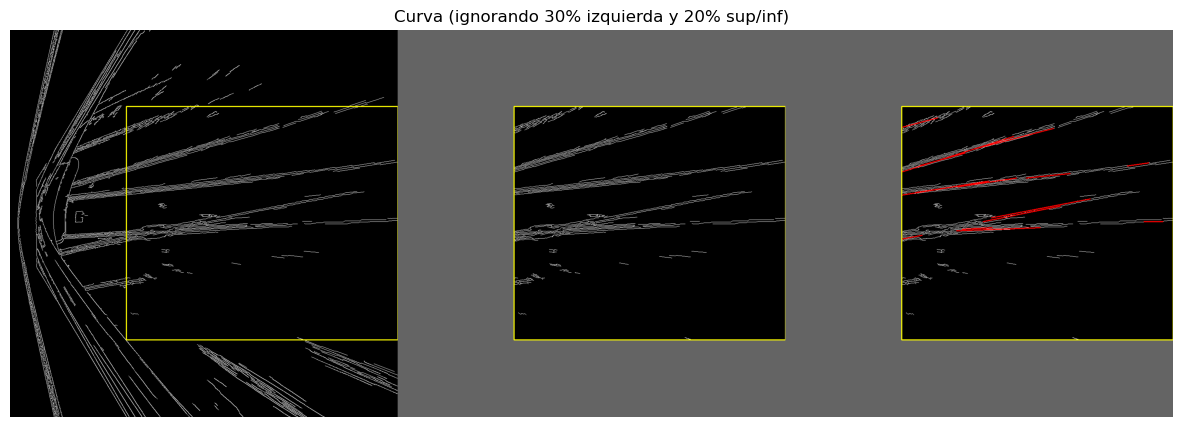

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def merge_lines(lines, angle_thresh=np.radians(5), gap_thresh=20):
    """
    Une líneas para las que la diferencia de ángulo es menor que angle_thresh y
    los extremos están relativamente cerca (gap_thresh en píxeles).
    Devuelve una lista de líneas fusionadas: cada línea es [x1, y1, x2, y2].
    """
    if lines is None:
        return []

    merged = []
    for line in lines[:,0]:
        merged.append(list(line))
    
    changed = True
    while changed:
        changed = False
        new_lines = []
        used = [False]*len(merged)
        for i in range(len(merged)):
            if used[i]:
                continue
            l1 = merged[i]
            x1,y1,x2,y2 = l1
            ang1 = np.arctan2(y2-y1, x2-x1)
            merged_line = l1.copy()
            used[i] = True
            for j in range(i+1, len(merged)):
                if used[j]:
                    continue
                l2 = merged[j]
                x3,y3,x4,y4 = l2
                ang2 = np.arctan2(y4-y3, x4-x3)
                if abs(ang1 - ang2) < angle_thresh:
                    # Chequeo de cercanía: si alguno de los extremos está cercano al otro
                    d1 = np.hypot(x1-x3, y1-y3)
                    d2 = np.hypot(x1-x4, y1-y4)
                    d3 = np.hypot(x2-x3, y2-y3)
                    d4 = np.hypot(x2-x4, y2-y4)
                    if min(d1, d2, d3, d4) < gap_thresh:
                        # Fusionar extendiendo los extremos
                        pts = np.array([[merged_line[0], merged_line[1]], [merged_line[2], merged_line[3]],
                                        [l2[0], l2[1]], [l2[2], l2[3]]])
                        # Elegir los extremos más alejados
                        dists = np.linalg.norm(pts[:,None]-pts, axis=2)
                        i1, i2 = np.unravel_index(np.argmax(dists), dists.shape)
                        merged_line = [int(pts[i1,0]), int(pts[i1,1]), int(pts[i2,0]), int(pts[i2,1])]
                        used[j] = True
                        changed = True
            new_lines.append(merged_line)
        merged = new_lines
    return merged

def es_tramo_curvo(edge_img,
                   rho=1,
                   theta=np.pi/180,
                   threshold=50,
                   min_line_len=50,
                   max_line_gap=5,
                   var_umbral=0.1):
    """
    Devuelve (is_curve, merged_lines) tras aplicar Hough a edge_img.
    Primero se obtienen las líneas y luego se fusionan aquellas que sean 
    continuación de otras (si su diferencia de ángulo es pequeña y están cerca).
    """
    lines = cv2.HoughLinesP(edge_img,
                            rho, theta, threshold,
                            minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    if lines is None:
        return False, None

    # Fusionar líneas con la función merge_lines
    merged_lines = merge_lines(lines, angle_thresh=np.radians(5), gap_thresh=20)
    
    # Calculo de la varianza de los ángulos de las líneas fusionadas:
    thetas = []
    for x1,y1,x2,y2 in merged_lines:
        thetas.append(np.arctan2((y2-y1),(x2-x1)))
    thetas = np.array(thetas)
    var = np.var(thetas)
    return (var > var_umbral), merged_lines

# --- Parámetros ---
EDGE_PATH = "C:/Users/usuario/Desktop/CAF/VS_CAF/CAF/Data_3D_2D/Train/output_canny_train/bev_000_canny.png"
edge = cv2.imread(EDGE_PATH, cv2.IMREAD_GRAYSCALE)
if edge is None:
    raise FileNotFoundError(EDGE_PATH)

h, w = edge.shape

# ---------------------------------------------------
# Construcción de la máscara para ignorar zonas:
#  - 30% izquierda
#  - 20% superior
#  - 20% inferior
left_cut   = int(0.3 * w)
top_cut    = int(0.2 * h)
bottom_cut = int(0.2 * h)

mask = np.ones_like(edge, dtype=np.uint8)
mask[:, :left_cut]          = 0       # izquierda
mask[:top_cut, :]           = 0       # arriba
mask[h-bottom_cut:, :]      = 0       # abajo

# Aplica la máscara
edge_masked = cv2.bitwise_and(edge, edge, mask=mask)

# Aplica Hough sobre la imagen enmascarada utilizando la fusión de líneas
curva, merged_lines = es_tramo_curvo(
    edge_masked,
    rho=1,
    theta=np.pi/180,
    threshold=50,
    min_line_len=50,
    max_line_gap=5,
    var_umbral=0.15
)

print("¿Curva? ", curva)

# --- Visualización ---

# Imagen original a color
vis_orig = cv2.cvtColor(edge, cv2.COLOR_GRAY2BGR)

# Imagen enmascarada con zona ignorada en gris claro
vis_mask = cv2.cvtColor(edge_masked, cv2.COLOR_GRAY2BGR)
vis_mask[mask==0] = (100,100,100)

# Imagen enmascarada + líneas detectadas (fusionadas)
vis_lines = vis_mask.copy()
if merged_lines is not None:
    for x1,y1,x2,y2 in merged_lines:
        cv2.line(vis_lines, (x1,y1), (x2,y2), (0,0,255), 2)

# Pinta un recuadro indicando la región usada
cv2.rectangle(vis_orig,      (left_cut, top_cut), (w, h-bottom_cut), (0,255,255), 2)
cv2.rectangle(vis_mask,      (left_cut, top_cut), (w, h-bottom_cut), (0,255,255), 2)
cv2.rectangle(vis_lines,     (left_cut, top_cut), (w, h-bottom_cut), (0,255,255), 2)

# Monta canvas y muestra
canvas = np.hstack([vis_orig, vis_mask, vis_lines])
plt.figure(figsize=(15,6))
plt.imshow(canvas[:,:,::-1])
plt.axis('off')
plt.title(f"{'Curva' if curva else 'Recta'} (ignorando 30% izquierda y 20% sup/inf)")
plt.show()

In [ ]:
'''TRAIN EGO-PATH DETECTOR (CROPPED IMAGE)'''

In [3]:
import sys
sys.path.insert(0, "C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection")

In [4]:

import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
from PIL import Image

from src.utils.interface import Detector
from src.utils.visualization import draw_egopath

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

base_path = os.path.dirname("C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection/")
os.makedirs(os.path.join(base_path, "output_crop"), exist_ok=True)

classification_model_path = os.path.join(base_path,"egopath", "weights", "fortuitous-goat-12")
regression_model_path = os.path.join(base_path,"egopath","weights", "chromatic-laughter-5")
segmentation_model_path = os.path.join(base_path,"egopath", "weights", "twinkling-rocket-21")

# Cargar la imagen original
img = Image.open(os.path.join("C:/Users/usuario/Desktop/CAF/VS_CAF/CAF/Data_3D_2D/Train/input", "images", "tren1.png"))

# Obtener dimensiones de la imagen
width, height = img.size

# Calcular nuevos límites: quita 10% de izquierda y derecha, y 30% inferior.
left = int(0.1 * width)
right = int(0.9 * width)
top = 0
bottom = int(0.7 * height)  # Se queda el 70% superior (se quita el 30% de abajo)

# Realizar el crop
img = img.crop((left, top, right, bottom))
to_test = (
    list(range(1, 5))
)

# 1) Inference without cropping
if 1 in to_test:
    detector = Detector(
        model_path=regression_model_path,
        crop_coords=None,
        runtime="pytorch",
        device=device,
    )
    egopath = detector.detect(img)
    vis = draw_egopath(img, egopath)
    vis.save(os.path.join(base_path, "output_crop", "demo1.jpg"))

# 2) Inference with manual cropping
if 2 in to_test:
    crop_coords = (580, 270, 1369, 1079)
    detector = Detector(regression_model_path, crop_coords, "pytorch", device)
    egopath = detector.detect(img)
    vis = draw_egopath(img, egopath, crop_coords=detector.get_crop_coords())
    vis.save(os.path.join(base_path, "output_crop", "demo2.jpg"))

# 3) Inference with automatic cropping
if 3 in to_test:
    detector = Detector(regression_model_path, "auto", "pytorch", device)
    for _ in range(50):  # multiple iterations to get a stable crop
        crop_coords = detector.get_crop_coords()
        egopath = detector.detect(img)
    vis = draw_egopath(img, egopath, crop_coords=crop_coords)
    vis.save(os.path.join(base_path, "output_crop", "demo3.jpg"))

# 4) Methods (classification, regression, segmentation) can be used interchangeably
if 4 in to_test:
    crop_coords = (580, 270, 1369, 1079)
    models = (
        classification_model_path,
        regression_model_path,
        segmentation_model_path,
    )
    dst = Image.new("RGB", (img.width * len(models), img.height))
    for i, model_path in enumerate(models):
        detector = Detector(model_path, crop_coords, "pytorch", device)
        pred = detector.detect(img)
        vis = draw_egopath(img, pred, crop_coords=detector.get_crop_coords())
        dst.paste(vis, (img.width * i, 0))
    dst.save(os.path.join(base_path, "output_crop", "demo4.jpg"))



In [ ]:
'''TRAIN EGO-PATH DETECTOR (DEFISHERED IMAGE)'''

In [5]:
from defisheye import Defisheye
import os

dtype = 'linear'
format = 'fullframe'
fov = 185
pfov = 120

img = "C:/Users/usuario/Desktop/CAF/VS_CAF/CAF/Data_3D_2D/Train/input/images/tren1.png"
base_path = "C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection"
os.makedirs(os.path.join(base_path, "output_fisheyed"), exist_ok=True)
img_out = f"{base_path}/output_fisheyed/defisheated_{dtype}_{format}_{pfov}_{fov}.jpg"

obj = Defisheye(img, dtype=dtype, format=format, fov=fov, pfov=pfov)

# To save image locally 
obj.convert(outfile=img_out)

# To use the converted image in memory

array([[[177, 179, 164],
        [177, 180, 165],
        [177, 180, 165],
        ...,
        [135, 139, 134],
        [141, 146, 142],
        [144, 149, 145]],

       [[177, 178, 164],
        [177, 179, 164],
        [177, 180, 165],
        ...,
        [154, 159, 154],
        [155, 161, 156],
        [153, 160, 153]],

       [[178, 178, 164],
        [177, 178, 164],
        [176, 179, 164],
        ...,
        [165, 171, 165],
        [150, 157, 150],
        [143, 151, 142]],

       ...,

       [[ 88,  79,  65],
        [ 86,  77,  63],
        [ 84,  75,  61],
        ...,
        [ 80,  79,  78],
        [ 79,  79,  79],
        [ 79,  79,  79]],

       [[ 87,  78,  64],
        [ 85,  76,  62],
        [ 84,  75,  61],
        ...,
        [ 80,  78,  77],
        [ 79,  78,  78],
        [ 79,  79,  78]],

       [[ 86,  77,  63],
        [ 84,  75,  61],
        [ 85,  76,  62],
        ...,
        [ 79,  77,  77],
        [ 79,  78,  77],
        [ 78,  78,  78]]

In [6]:
'''CROP+DEFISHEATED IMAGE'''

'CROP+DEFISHEATED IMAGE'

In [7]:
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
from PIL import Image

from src.utils.interface import Detector
from src.utils.visualization import draw_egopath

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

base_path = os.path.dirname("C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection/")
os.makedirs(os.path.join(base_path, "output_fisheyed"), exist_ok=True)

classification_model_path = os.path.join(base_path,"egopath", "weights", "fortuitous-goat-12")
regression_model_path = os.path.join(base_path,"egopath","weights", "chromatic-laughter-5")
segmentation_model_path = os.path.join(base_path,"egopath", "weights", "twinkling-rocket-21")

# Cargar la imagen original
img = Image.open(os.path.join("C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection/output_fisheyed","defisheated_linear_fullframe_120_180.jpg"))

# Obtener dimensiones de la imagen
width, height = img.size

# Calcular los límites para mantener toda la imagen excepto el 30% inferior
left = 0
right = width
top = 0
bottom = int(0.7 * height)  # Se conserva el 70% superior de la imagen

# Realizar el crop
img = img.crop((left, top, right, bottom))

# 1) Inference without cropping
if 1 in to_test:
    detector = Detector(
        model_path=regression_model_path,
        crop_coords=None,
        runtime="pytorch",
        device=device,
    )
    egopath = detector.detect(img)
    vis = draw_egopath(img, egopath)
    vis.save(os.path.join(base_path, "output_fisheyed", "demo1.jpg"))

# 2) Inference with manual cropping
if 2 in to_test:
    crop_coords = (580, 270, 1369, 1079)
    detector = Detector(regression_model_path, crop_coords, "pytorch", device)
    egopath = detector.detect(img)
    vis = draw_egopath(img, egopath, crop_coords=detector.get_crop_coords())
    vis.save(os.path.join(base_path, "output_fisheyed", "demo2.jpg"))

# 3) Inference with automatic cropping
if 3 in to_test:
    detector = Detector(regression_model_path, "auto", "pytorch", device)
    for _ in range(50):  # multiple iterations to get a stable crop
        crop_coords = detector.get_crop_coords()
        egopath = detector.detect(img)
    vis = draw_egopath(img, egopath, crop_coords=crop_coords)
    vis.save(os.path.join(base_path, "output_fisheyed", "demo3.jpg"))

# 4) Methods (classification, regression, segmentation) can be used interchangeably
if 4 in to_test:
    crop_coords = (580, 270, 1369, 1079)
    models = (
        classification_model_path,
        regression_model_path,
        segmentation_model_path,
    )
    dst = Image.new("RGB", (img.width * len(models), img.height))
    for i, model_path in enumerate(models):
        detector = Detector(model_path, crop_coords, "pytorch", device)
        pred = detector.detect(img)
        vis = draw_egopath(img, pred, crop_coords=detector.get_crop_coords())
        dst.paste(vis, (img.width * i, 0))
    dst.save(os.path.join(base_path, "output_fisheyed", "demo4.jpg"))



In [ ]:
'''Como podemos observar el modelo que mejor funciona es el de segmentación así 
que usaremos ese para trackear las vías. Más concretamente, usaremos el modelo
twinkling-rocket-21. Para ello, el input debe ser una imagen o vídeo que vamos a
croppear y defishear'''

In [8]:
import sys
sys.path.insert(0, "C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection")
from detect import parse_arguments, main

# The error indicates that CUDA is not available in your PyTorch build.
# To run on CPU, include the "--device" flag set to "cpu".
sys.argv = [
    "detect.py",
    "brilliant-horse-15",  # Model name selection
    "C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection/output_fisheyed/defisheated_linear_fullframe_120_180.jpg",  # Input file path
    "--output", "C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection/output_final",  # Output directory path
    "--device", "cpu"  # Force usage of CPU since CUDA is not available
]

args = parse_arguments()
main(args)


Detecting ego-path in C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection/output_fisheyed/defisheated_linear_fullframe_120_180.jpg...

Inference complete. Output saved to C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection/output_final\defisheated_linear_fullframe_120_180_out.jpg


In [9]:
import sys
import os
from PIL import Image

sys.path.insert(0, "C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection")
from detect import parse_arguments, main

# Original input image path
input_path = "C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection/output_fisheyed/defisheated_linear_fullframe_120_180.jpg"
# Output directory path
output_dir = "C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection/output_final"

# Crop the bottom 30% from the input image before passing it to the model
img = Image.open(input_path)
width, height = img.size
cropped_img = img.crop((0, 0, width, int(0.7 * height)))  # remove bottom 30%
# Save the cropped image to the output directory
os.makedirs(output_dir, exist_ok=True)
cropped_path = os.path.join(output_dir,"pre_cropped","cropped_input.jpg")
cropped_img.save(cropped_path)

sys.argv = [
    "detect.py",
    "twinkling-rocket-21",  # Model name selection
    cropped_path,  # Cropped input file path
    "--output", output_dir,  # Output directory path
    "--device", "cpu"  # Force usage of CPU since CUDA is not available
]

args = parse_arguments()
main(args)


Detecting ego-path in C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection/output_final\pre_cropped\cropped_input.jpg...

Detecting ego-path in C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection/output_final\pre_cropped\cropped_input.jpg...

Inference complete. Output saved to C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection/output_final\cropped_input_out.jpg

Inference complete. Output saved to C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection/output_final\cropped_input_out.jpg


In [ ]:
'''Nos quedamos solo con el TRACK de la vía'''

In [6]:
import cv2
import numpy as np
import os

input_path = "C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection/output_final/cropped_input_out.jpg"  # Image with the track
output_path = "C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection/only_track/track.jpg"      # Intermediate extracted track image
final_output_path = "C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection/only_track/track_cropped.jpg"  # Final cropped output image

# Load the original image
image = cv2.imread(input_path)
if image is None:
    raise FileNotFoundError(f"Image not found at: {input_path}")

# Convert image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define adjusted thresholds for purple to capture the track
lower_morado = np.array([125, 50, 50])
upper_morado = np.array([155, 255, 255])

# Create a mask for the purple track
mask = cv2.inRange(hsv, lower_morado, upper_morado)

# Optionally, apply morphological operations to clean up the mask
kernel = np.ones((5, 5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# Extract the track from the image; all other areas become black.
extracted_track = cv2.bitwise_and(image, image, mask=mask)

# Ensure the intermediate output directory exists and save the extracted track image.
os.makedirs(os.path.dirname(output_path), exist_ok=True)
cv2.imwrite(output_path, extracted_track)
print("Extracted track image saved at:", output_path)

# -------------------------------------------
# Now perform the crop with the new specifications:
# - Remove the top 71% of the image, i.e. keep from y = 71% to y = 90% (thus also removing bottom 10%).
# - Remove 30% of the image width from the left and 40% from the right,
#   i.e. keep the horizontal region from x = 30% to x = 60% of the width.
ex_height, ex_width = extracted_track.shape[:2]

x1 = int(ex_width * 0.30)
x2 = int(ex_width * 0.60)
y1 = int(ex_height * 0.71)
y2 = int(ex_height * 0.90)

final_cropped = extracted_track[y1:y2, x1:x2]

# Ensure the final output directory exists and save the final cropped image.
os.makedirs(os.path.dirname(final_output_path), exist_ok=True)
cv2.imwrite(final_output_path, final_cropped)


Extracted track image saved at: C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection/only_track/track.jpg


True

In [ ]:
'''PARA VIDEO'''

In [1]:
import sys
import os
import cv2

sys.path.insert(0, "C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection")
from detect import parse_arguments, main

# Original input video path
input_path = "C:/Users/usuario/Desktop/CAF/Tranvía_zgz/clips/clip2.mp4"  # Change this path to your video file
# Output directory path (updated as requested)
output_dir = "C:/Users/usuario/Desktop/CAF/Tranvía_zgz/result"

# Crop the bottom 30% from the input video before passing it to the model
os.makedirs(os.path.join(output_dir, "pre_cropped"), exist_ok=True)
cropped_path = os.path.join(output_dir, "pre_cropped", "cropped_input.mp4")

cap = cv2.VideoCapture(input_path)
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cropped_height = int(0.7 * height)  # Remove bottom 30%

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(cropped_path, fourcc, fps, (width, cropped_height))

while True:
    ret, frame = cap.read()
    if not ret:
        break
    # Crop the bottom 30% (keep the top 70%)
    cropped_frame = frame[0:cropped_height, :]
    out.write(cropped_frame)

cap.release()
out.release()

sys.argv = [
    "detect.py",
    "twinkling-rocket-21",  # Model name selection
    cropped_path,           # Cropped input video path
    "--output", output_dir, # Updated output directory path
    "--device", "cpu"       # Force usage of CPU since CUDA is not available
]

args = parse_arguments()
main(args)


Detecting ego-path in C:/Users/usuario/Desktop/CAF/Tranvía_zgz/result\pre_cropped\cropped_input.mp4...

FRAMES: 1024 | RESOLUTION: 1920x756 | FPS: 30.0
Processed 1024/1024 frames (100.00%)

Inference complete. Output saved to C:/Users/usuario/Desktop/CAF/Tranvía_zgz/result\cropped_input_out.mp4


In [ ]:
'''TRAPECIO PARA IMAGEN'''

In [2]:
import cv2
import numpy as np
import os

# Set input image path
input_path = "C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection/only_track/track_cropped.jpg"  # Replace with your image path
# Set output image file path (including file name and extension)
output_path = "C:/Users/usuario/Desktop/CAF/VS_CAF/train-ego-path-detection/fold_change/trapezoid_percent.jpg"  # Replace with desired output path

# Load the image
image = cv2.imread(input_path)
if image is None:
    raise FileNotFoundError("Image not found at: " + input_path)

# Get image dimensions
height, width = image.shape[:2]

# Define the four vertices of the trapezoid in percentage (x%, y%) relative to image dimensions.
# Adjust these percentages as needed.
pt1_percent = (53.5, 2)   # Top-left corner
pt2_percent = (57.5, 2)   # Top-right corner
pt3_percent = (82, 100)   # Bottom-right corner
pt4_percent = (29, 100)   # Bottom-left corner

# Convert percentage coordinates to pixel values.
pt1 = (int(width * pt1_percent[0] / 100), int(height * pt1_percent[1] / 100))
pt2 = (int(width * pt2_percent[0] / 100), int(height * pt2_percent[1] / 100))
pt3 = (int(width * pt3_percent[0] / 100), int(height * pt3_percent[1] / 100))
pt4 = (int(width * pt4_percent[0] / 100), int(height * pt4_percent[1] / 100))

# Create an array of points for the trapezoid
pts = np.array([pt1, pt2, pt3, pt4], np.int32).reshape((-1, 1, 2))

# Draw the trapezoid (outline in green, thickness = 3)
cv2.polylines(image, [pts], isClosed=True, color=(0, 0, 255), thickness=1)
# Uncomment the following line to fill the trapezoid with green:
# cv2.fillPoly(image, [pts], color=(0, 255, 0))

# Ensure the output directory exists and save the resulting image
os.makedirs(os.path.dirname(output_path), exist_ok=True)
cv2.imwrite(output_path, image)


True

In [ ]:
'''Cálculo área fuera del trapecio y DETERMINACIÓN DE CURVA'''

In [ ]:
import cv2
import numpy as np
import os

# Input path: image with neon green track and red trapezoid (outline)
input_path = r"C:\Users\usuario\Desktop\CAF\VS_CAF\train-ego-path-detection\fold_change\trapezoid_percent.jpg"
output_path = r"C:\Users\usuario\Desktop\CAF\VS_CAF\train-ego-path-detection\fold_change\visualized_zoom_result.jpg"

# Cargar la imagen
image = cv2.imread(input_path)
if image is None:
    raise FileNotFoundError("No se encontró la imagen en: " + input_path)

height, width = image.shape[:2]

# ---------- EXTRAER EL TRACK (verde fosforito) ----------
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower_morado = np.array([35, 40, 40])
upper_morado = np.array([85, 255, 255])
track_mask = cv2.inRange(hsv, lower_morado, upper_morado)
kernel = np.ones((3, 3), np.uint8)
track_mask = cv2.dilate(track_mask, kernel, iterations=1)

# ---------- CREAR LA MÁSCARA DEL TRAPECIO (rellena) ----------
# Coordenadas en porcentajes (según lo indicado)
pt1 = (int(width * 53.5 / 100), int(height * 2 / 100))
pt2 = (int(width * 57.5 / 100), int(height * 2 / 100))
pt3 = (int(width * 82 / 100), int(height * 100 / 100))
pt4 = (int(width * 29 / 100), int(height * 100 / 100))
trap_pts = np.array([pt1, pt2, pt3, pt4], dtype=np.int32)
trapezoid_mask = np.zeros((height, width), dtype=np.uint8)
cv2.fillPoly(trapezoid_mask, [trap_pts], 255)

# ---------- CALCULAR ÁREAS ----------
total_track_area = cv2.countNonZero(track_mask)
inside_mask = cv2.bitwise_and(track_mask, trapezoid_mask)
inside_area = cv2.countNonZero(inside_mask)
outside_area = total_track_area - inside_area
percent_outside = (outside_area / total_track_area * 100) if total_track_area > 0 else 0

print(f"Área total del track: {total_track_area} píxeles")
print(f"Área del track dentro del trapecio: {inside_area} píxeles")
print(f"Área del track fuera del trapecio: {outside_area} píxeles")
print(f"Porcentaje del track fuera del trapecio: {percent_outside:.2f}%")

# ---------- VISUALIZAR EL ÁREA FUERA DEL TRAPECIO ----------
outside_mask = cv2.bitwise_and(track_mask, cv2.bitwise_not(trapezoid_mask))
overlay = image.copy()
overlay[outside_mask > 0] = (0, 255, 255)  # Amarillo
alpha = 0.5
visualized = cv2.addWeighted(image, 1 - alpha, overlay, alpha, 0)

# Añadir texto con el porcentaje y resultado, en fuente más pequeña (font scale = 0.3)
text = f"{percent_outside:.2f}% fuera -> {'Curve' if percent_outside > 2 else 'Straight'}"
cv2.putText(visualized, text, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)

# ---------- APLICAR ZOOM ----------
zoom_factor = 2.0
visualized_zoom = cv2.resize(visualized, (0, 0), fx=zoom_factor, fy=zoom_factor, interpolation=cv2.INTER_CUBIC)

os.makedirs(os.path.dirname(output_path), exist_ok=True)
cv2.imwrite(output_path, visualized_zoom)


Área total del track: 10363 píxeles
Área del track dentro del trapecio: 10127 píxeles
Área del track fuera del trapecio: 236 píxeles
Porcentaje del track fuera del trapecio: 2.28%


True

In [ ]:
'''VIDEO'''

In [ ]:
'''Tenemos ya el trackeo, vamos a quedarnos solo con trackeo'''

In [11]:
import cv2
import numpy as np
import os

# Rutas
input_video = r"C:\Users\usuario\Desktop\CAF\Tranvía_zgz\result\cropped_input_out.mp4"
output_dir  = r"C:\Users\usuario\Desktop\CAF\Tranvía_zgz\result\only_track_video"
os.makedirs(output_dir, exist_ok=True)

extracted_vid = os.path.join(output_dir, "track_extracted.mp4")
final_vid     = os.path.join(output_dir, "track_extracted_cropped.mp4")

# Abre vídeo
cap = cv2.VideoCapture(input_video)
fps = cap.get(cv2.CAP_PROP_FPS)
w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Writers
fourcc   = cv2.VideoWriter_fourcc(*"mp4v")
out_full = cv2.VideoWriter(extracted_vid, fourcc, fps, (w, h))
x1, x2 = int(w*0.30), int(w*0.60)
y1, y2 = int(h*0.71), int(h*0.90)
out_crop = cv2.VideoWriter(final_vid, fourcc, fps, (x2-x1, y2-y1))

# Definir thresholds para captar un morado intenso (track)
lower_morado = np.array([125, 50, 50])
upper_morado = np.array([155, 255, 255])
kernel = np.ones((5, 5), np.uint8)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    hsv  = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_morado, upper_morado)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  kernel)

    extracted = cv2.bitwise_and(frame, frame, mask=mask)
    out_full.write(extracted)

    crop = extracted[y1:y2, x1:x2]
    out_crop.write(crop)

cap.release()
out_full.release()
out_crop.release()

print("Vídeo extraído en:", extracted_vid)


Vídeo extraído en: C:\Users\usuario\Desktop\CAF\Tranvía_zgz\result\only_track_video\track_extracted.mp4


In [ ]:
'''TRAPECIO PARA EL VÍDEO'''

In [30]:
import cv2
import numpy as np
import os

# Define input and output video paths for the video with the trapezoid overlay
input_video_path = r"C:\Users\usuario\Desktop\CAF\Tranvía_zgz\result\only_track_video\track_extracted_cropped.mp4"
output_video_path = r"C:\Users\usuario\Desktop\CAF\Tranvía_zgz\result\only_track_video\track_extracted_trapezoid.mp4"

# Open the input video
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    raise FileNotFoundError("Video not found at: " + input_video_path)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Setup the VideoWriter for the output video
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Define the trapezoid vertices in percentage (x%, y%) relative to frame dimensions
pt1_percent = (60, 2)   # Top-left corner
pt2_percent = (62, 2)   # Top-right corner
pt3_percent = (76, 100)   # Bottom-right corner
pt4_percent = (46, 100)   # Bottom-left corner

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Compute pixel coordinates for the trapezoid using current frame dimensions
    pt1 = (int(frame_width * pt1_percent[0] / 100), int(frame_height * pt1_percent[1] / 100))
    pt2 = (int(frame_width * pt2_percent[0] / 100), int(frame_height * pt2_percent[1] / 100))
    pt3 = (int(frame_width * pt3_percent[0] / 100), int(frame_height * pt3_percent[1] / 100))
    pt4 = (int(frame_width * pt4_percent[0] / 100), int(frame_height * pt4_percent[1] / 100))

    # Create an array of points for the trapezoid
    pts = np.array([pt1, pt2, pt3, pt4], np.int32).reshape((-1, 1, 2))
    
    # Draw the trapezoid outline on the frame (using red color; thickness = 1)
    cv2.polylines(frame, [pts], isClosed=True, color=(0, 0, 255), thickness=1)
    
    # Write the frame with the trapezoid overlay to the output video
    out.write(frame)

cap.release()
out.release()
print("Video processed and saved at:", output_video_path)

Video processed and saved at: C:\Users\usuario\Desktop\CAF\Tranvía_zgz\result\only_track_video\track_extracted_trapezoid.mp4


In [ ]:
'''CALCULO DEL AREA FUERA DEL TRAPECIO EN VIDEO'''

In [44]:
import cv2
import numpy as np
import os

# Updated paths
input_video_path = r"C:\Users\usuario\Desktop\CAF\Tranvía_zgz\result\only_track_video\track_extracted_trapezoid.mp4"
output_video_path = r"C:\Users\usuario\Desktop\CAF\Tranvía_zgz\result\only_track_video\track_extracted_curvayn.mp4"

# Open the input video
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    raise FileNotFoundError("Video not found at: " + input_video_path)

# Get video properties
fps         = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Zoom factor for output frames
zoom_factor = 2.0

# Instead of eliminating the right 20%, now eliminate the left 20%
# So we keep the right 80% of the frame.
crop_start = int(frame_width * 0.20)
cropped_width  = frame_width - crop_start
cropped_height = frame_height

# Calculate final output dimensions after zoom
new_width  = int(cropped_width * zoom_factor)
new_height = int(cropped_height * zoom_factor)

# Setup the VideoWriter for the output video with zoomed dimensions
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output_video_path, fourcc, fps, (new_width, new_height))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # ---------- EXTRAER EL TRACK (usando umbral para morado intenso) ----------
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # Umbrales para captar tonos morados intensos
    lower_morado = np.array([125, 50, 50])
    upper_morado = np.array([155, 255, 255])
    track_mask = cv2.inRange(hsv, lower_morado, upper_morado)
    kernel = np.ones((3, 3), np.uint8)
    track_mask = cv2.dilate(track_mask, kernel, iterations=1)

    # ---------- CREAR LA MÁSCARA DEL TRAPECIO (rellena) ----------
    # Usando los puntos en porcentaje:
    # pt1_percent = (60, 2)   # Top-left
    # pt2_percent = (62, 2)   # Top-right
    # pt3_percent = (76, 100) # Bottom-right
    # pt4_percent = (46, 100) # Bottom-left
    pt1 = (int(frame_width * 60 / 100), int(frame_height * 2 / 100))
    pt2 = (int(frame_width * 62 / 100), int(frame_height * 2 / 100))
    pt3 = (int(frame_width * 76 / 100), int(frame_height * 100 / 100))
    pt4 = (int(frame_width * 46 / 100), int(frame_height * 100 / 100))
    trap_pts = np.array([pt1, pt2, pt3, pt4], dtype=np.int32)
    trapezoid_mask = np.zeros((frame_height, frame_width), dtype=np.uint8)
    cv2.fillPoly(trapezoid_mask, [trap_pts], 255)

    # ---------- CALCULAR ÁREAS ----------
    total_track_area = cv2.countNonZero(track_mask)
    inside_mask = cv2.bitwise_and(track_mask, trapezoid_mask)
    inside_area = cv2.countNonZero(inside_mask)
    outside_area = total_track_area - inside_area
    percent_outside = (outside_area / total_track_area * 100) if total_track_area > 0 else 0

    # ---------- VISUALIZAR EL ÁREA FUERA DEL TRAPECIO ----------
    outside_mask = cv2.bitwise_and(track_mask, cv2.bitwise_not(trapezoid_mask))
    overlay = frame.copy()
    overlay[outside_mask > 0] = (0, 255, 255)  # Amarillo para áreas fuera del trapecio
    alpha = 0.5
    visualized = cv2.addWeighted(frame, 1 - alpha, overlay, alpha, 0)

    # ---------- RECORTAR LA FRANJA IZQUIERDA (eliminar el 20%) ----------
    # Se conserva solo el 80% derecho del fotograma, eliminando el 20% izquierdo
    cropped_frame = visualized[:, crop_start:]

    # ---------- AÑADIR TEXTO MÁS HACIA LA DERECHA ----------
    text = f"{percent_outside:.2f}% fuera -> {'Curve' if percent_outside > 2 else 'Straight'}"
    text_x = int(cropped_frame.shape[1] * 0.7)  # Posición en base al fotograma recortado
    text_y = 20
    cv2.putText(cropped_frame, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)

    # ---------- APLICAR ZOOM ----------
    visualized_zoom = cv2.resize(cropped_frame, (0, 0), fx=zoom_factor, fy=zoom_factor, interpolation=cv2.INTER_CUBIC)

    # Write the processed frame into the output video
    out.write(visualized_zoom)

cap.release()
out.release()
print("Video processed and saved at:", output_video_path)

Video processed and saved at: C:\Users\usuario\Desktop\CAF\Tranvía_zgz\result\only_track_video\track_extracted_curvayn.mp4
